## LGMVIP Task 2 - Stock Market Prediction and Forecasting using Stack LSTM

## Import the necessary libraries

In [6]:
import math
import numpy as np
import pandas as pd
!pip install tensorflow
import tensorflow as tf
!pip install pandas_datareader
import pandas_datareader as pdr
import matplotlib.pyplot as plt

## Loading the dataset

In [7]:
url = "https://raw.githubusercontent.com/mwitiderrick/stockprice/master/NSE-TATAGLOBAL.csv"
data = pd.read_csv(url)

## Exploring the dataset

In [8]:
data = data.sort_values(by=['Date'])
data.head()


,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
2034,2010-07-21,122.1,123.00,121.05,121.10,121.55,658666,803.56
2033,2010-07-22,120.3,122.00,120.25,120.75,120.90,293312,355.17
2032,2010-07-23,121.8,121.95,120.25,120.35,120.65,281312,340.31
2031,2010-07-26,120.1,121.00,117.10,117.10,117.60,658440,780.01
2030,2010-07-27,117.6,119.50,112.00,118.80,118.65,586100,694.98


In [9]:
data.tail()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
4,2018-09-24,233.55,239.20,230.75,234.00,233.30,3423509,7999.55
3,2018-09-25,233.30,236.75,232.00,236.25,236.10,2349368,5503.90
2,2018-09-26,240.00,240.00,232.50,235.00,234.25,2240909,5248.60
1,2018-09-27,234.55,236.80,231.10,233.80,233.25,5082859,11859.95
0,2018-09-28,234.05,235.95,230.20,233.50,233.75,3069914,7162.35


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2035 entries, 2034 to 0
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Date                  2035 non-null   object 
 1   Open                  2035 non-null   float64
 2   High                  2035 non-null   float64
 3   Low                   2035 non-null   float64
 4   Last                  2035 non-null   float64
 5   Close                 2035 non-null   float64
 6   Total Trade Quantity  2035 non-null   int64  
 7   Turnover (Lacs)       2035 non-null   float64
dtypes: float64(6), int64(1), object(1)
memory usage: 143.1+ KB


In [12]:
data.describe()

,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
count,2035.000000,2035.000000,2035.000000,2035.000000,2035.00000,2.035000e+03,2035.000000
mean,149.713735,151.992826,147.293931,149.474251,149.45027,2.335681e+06,3899.980565
std,48.664509,49.413109,47.931958,48.732570,48.71204,2.091778e+06,4570.767877
min,81.100000,82.800000,80.000000,81.000000,80.95000,3.961000e+04,37.040000
25%,120.025000,122.100000,118.300000,120.075000,120.05000,1.146444e+06,1427.460000
50%,141.500000,143.400000,139.600000,141.100000,141.25000,1.783456e+06,2512.030000
75%,157.175000,159.400000,155.150000,156.925000,156.90000,2.813594e+06,4539.015000
max,327.700000,328.750000,321.650000,325.950000,325.75000,2.919102e+07,55755.080000


## Selecting Close column for making Predictions

In [13]:
df = data.reset_index()['Close']
df.shape

(2035,)

In [14]:
df.head()

0    121.55
1    120.90
2    120.65
3    117.60
4    118.65
Name: Close, dtype: float64

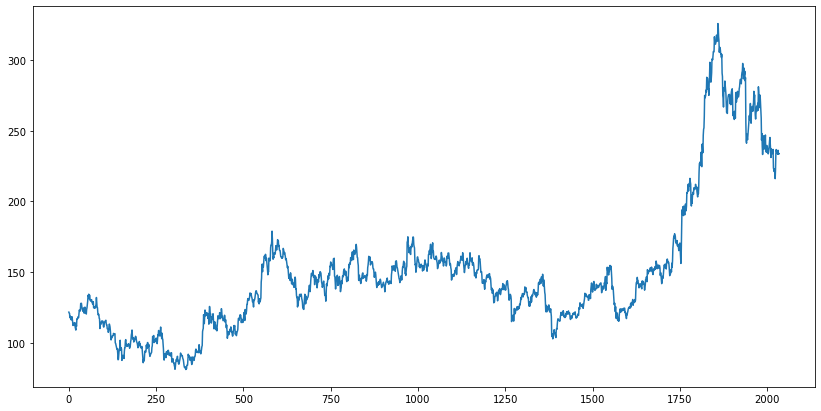

In [15]:
plt.figure(figsize=(14, 7))
plt.plot(df)
plt.show()

## Applying MinMaxScaler to scale the data

In [16]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
df = sc.fit_transform(np.array(df).reshape(-1,1))
df.shape

(2035, 1)

In [17]:
df

array([[0.16584967],
       [0.16319444],
       [0.1621732 ],
       ...,
       [0.62622549],
       [0.62214052],
       [0.62418301]])

## Splitting dataset into Training and Test set

In [18]:
train_size = int(len(df) * 0.80)
test_size = len(df) - train_size
train_size, test_size

(1628, 407)

In [19]:
train_data, test_data = df[0:train_size, :], df[train_size:len(df), :1]

In [20]:
train_data

array([[0.16584967],
       [0.16319444],
       [0.1621732 ],
       ...,
       [0.24877451],
       [0.25245098],
       [0.24795752]])

## Converting array of values to dataset matrix

In [21]:
def make_dataset(data, time_step):
	d1, d2 = [], []
	for i in range(len(data)-time_step-1):  
		d1.append(data[i:(i + time_step), 0])
		d2.append(data[i + time_step, 0])
	return np.array(d1), np.array(d2)

In [22]:
X_train, y_train = make_dataset(train_data, 100)
X_test, y_test = make_dataset(test_data, 100)

In [23]:
print(X_train.shape), print(y_train.shape)

(1527, 100)
(1527,)


(None, None)

## Reshaping the input to be in [Samples, Time Steps, Features] format

In [24]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

## Creating the LSTM model

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [26]:
model = Sequential()
model.add(LSTM(50, return_sequences = True, input_shape = (100, 1)))
model.add(LSTM(50, return_sequences = True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss = 'mean_squared_error', optimizer = 'adam')

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [29]:
model.fit(X_train, y_train, validation_data = (X_test,y_test), epochs = 100, batch_size = 64, verbose = 1)

Epoch 1/100
24/24 [==============================] - 9s 132ms/step - loss: 0.0074 - val_loss: 0.0260
Epoch 2/100
24/24 [==============================] - 3s 137ms/step - loss: 0.0013 - val_loss: 0.0065
Epoch 3/100
24/24 [==============================] - 3s 119ms/step - loss: 9.0522e-04 - val_loss: 0.0058
Epoch 4/100
24/24 [==============================] - 2s 90ms/step - loss: 8.5965e-04 - val_loss: 0.0047
Epoch 5/100
24/24 [==============================] - 2s 87ms/step - loss: 7.9977e-04 - val_loss: 0.0049
Epoch 6/100
24/24 [==============================] - 2s 92ms/step - loss: 7.6691e-04 - val_loss: 0.0045
Epoch 7/100
24/24 [==============================] - 2s 86ms/step - loss: 7.7067e-04 - val_loss: 0.0068
Epoch 8/100
24/24 [==============================] - 2s 87ms/step - loss: 7.1786e-04 - val_loss: 0.0055
Epoch 9/100
24/24 [==============================] - 2s 86ms/step - loss: 6.7730e-04 - val_loss: 0.0048
Epoch 10/100
24/24 [==============================] - 3s 107ms/step -

## Making predictions for training and test data

In [30]:
train_pred = sc.inverse_transform(model.predict(X_train))
test_pred = sc.inverse_transform(model.predict(X_test))

10/10 [==============================] - 0s 18ms/step


## Calculating RMSE for train and test data

In [31]:
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train, train_pred)), math.sqrt(mean_squared_error(y_test, test_pred))

(133.81914836851334, 244.74292675747273)

## Plotting training and test data predictions

In [32]:
look_back = 100
trainPredPlot = np.empty_like(df)
trainPredPlot[:, :] = np.nan
trainPredPlot[look_back:len(train_pred) + look_back, :] = train_pred

In [33]:
testPredPlot = np.empty_like(df)
testPredPlot[:, :] = np.nan
testPredPlot[len(train_pred) + (look_back*2) + 1:len(df) - 1, :] = test_pred

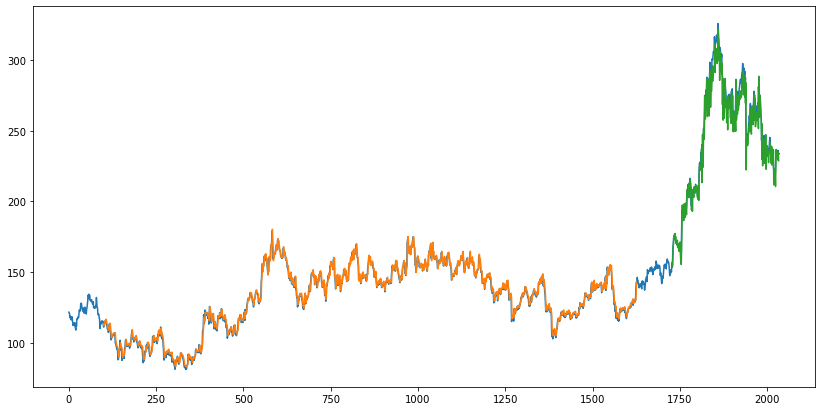

In [34]:
plt.figure(figsize=(14, 7))
plt.plot(sc.inverse_transform(df))
plt.plot(trainPredPlot)
plt.plot(testPredPlot)
plt.show()

In [35]:
len(test_data)

407

In [36]:
X_input = test_data[307:].reshape(1,-1)
X_input.shape

(1, 100)

In [37]:
temp = list(X_input)
temp = temp[0].tolist()

In [38]:
temp

[0.8527369281045751,
 0.8621323529411764,
 0.8345588235294117,
 0.84375,
 0.7146650326797386,
 0.6605392156862745,
 0.6542075163398693,
 0.6803513071895424,
 0.6689133986928104,
 0.6642156862745099,
 0.678921568627451,
 0.6913807189542482,
 0.7089460784313726,
 0.7226307189542485,
 0.7340686274509802,
 0.7212009803921569,
 0.749795751633987,
 0.7689950980392157,
 0.7446895424836601,
 0.7120098039215685,
 0.7467320261437909,
 0.7549019607843137,
 0.7604166666666667,
 0.7598039215686274,
 0.7465277777777777,
 0.7624591503267975,
 0.7706290849673203,
 0.8041258169934642,
 0.7810457516339868,
 0.7941176470588236,
 0.7602124183006536,
 0.7348856209150327,
 0.7240604575163399,
 0.7399918300653596,
 0.749795751633987,
 0.7614379084967322,
 0.7542892156862746,
 0.7475490196078431,
 0.769607843137255,
 0.7495915032679739,
 0.8171977124183007,
 0.8020833333333335,
 0.7773692810457518,
 0.7571486928104576,
 0.7937091503267975,
 0.7916666666666667,
 0.7714460784313726,
 0.7526552287581698,
 0.7269

## Getting predictions for next 30 days

In [39]:
list_output = []
num_steps=100
i = 0
while (i < 30):
    if(len(temp) > 100):
        X_input = np.array(temp[1:])
        print("Day {} input {}".format(i, X_input))
        X_input = X_input.reshape(1,-1)
        X_input = X_input.reshape((1, num_steps, 1))
        yhat = model.predict(X_input, verbose = 0)
        print("Day {} output {}".format(i, yhat))
        temp.extend(yhat[0].tolist())
        temp = temp[1:]
        list_output.extend(yhat.tolist())
        i = i + 1
    else:
        X_input = X_input.reshape((1, num_steps, 1))
        yhat = model.predict(X_input, verbose = 0)
        print(yhat[0])
        temp.extend(yhat[0].tolist())
        print(len(temp))
        list_output.extend(yhat.tolist())
        i = i + 1

print(list_output)

[0.61386716]
101
Day 1 input [0.86213235 0.83455882 0.84375    0.71466503 0.66053922 0.65420752
 0.68035131 0.6689134  0.66421569 0.67892157 0.69138072 0.70894608
 0.72263072 0.73406863 0.72120098 0.74979575 0.7689951  0.74468954
 0.7120098  0.74673203 0.75490196 0.76041667 0.75980392 0.74652778
 0.76245915 0.77062908 0.80412582 0.78104575 0.79411765 0.76021242
 0.73488562 0.72406046 0.73999183 0.74979575 0.76143791 0.75428922
 0.74754902 0.76960784 0.7495915  0.81719771 0.80208333 0.77736928
 0.75714869 0.79370915 0.79166667 0.77144608 0.75265523 0.72691993
 0.6629902  0.68198529 0.64419935 0.62152778 0.6439951  0.66319444
 0.67544935 0.63705065 0.64603758 0.65890523 0.65870098 0.67790033
 0.63194444 0.63112745 0.62785948 0.64767157 0.63991013 0.63480392
 0.63868464 0.62336601 0.62745098 0.63970588 0.64705882 0.66196895
 0.67075163 0.65196078 0.63112745 0.61294935 0.6376634  0.62254902
 0.62745098 0.63337418 0.62642974 0.63623366 0.58312908 0.57781863
 0.57230392 0.58006536 0.57618464

In [40]:
new_day = np.arange(1, 101)
pred_day = np.arange(101, 131)

In [41]:
len(df)

2035

## Plotting the prediction data

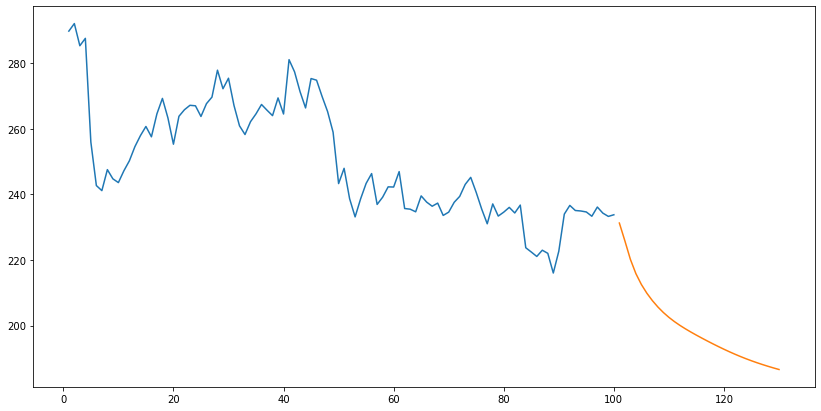

In [42]:
plt.figure(figsize=(14, 7))
plt.plot(new_day, sc.inverse_transform(df[1935:]))
plt.plot(pred_day, sc.inverse_transform(list_output))
plt.show()


In [43]:
df = df.tolist()
df.extend(list_output)

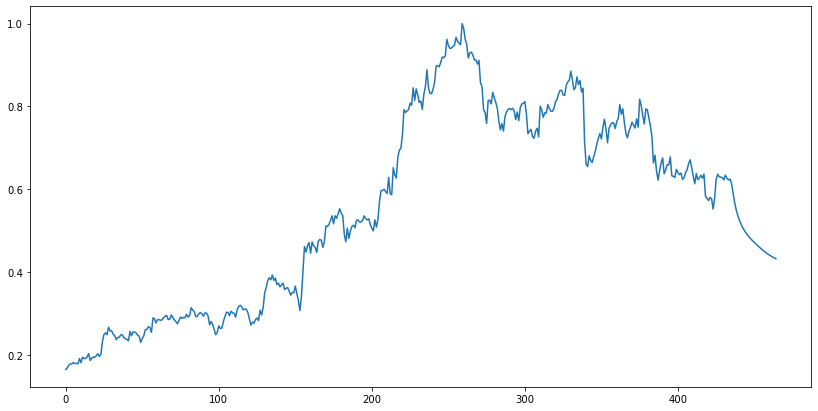

In [44]:
plt.figure(figsize=(14, 7))
plt.plot(df[1600:])
plt.show()